In [60]:
import numpy as np
import pandas as pd

from stanscofi.utils import load_dataset
from stanscofi.datasets import Dataset
from stanscofi.training_testing import cv_training
from stanscofi.training_testing import weakly_correlated_split, random_simple_split, metrics_list
from stanscofi.validation import compute_metrics, plot_metrics
from stanscofi.validation import AUC, Rscore, MRR, RP, PrecisionK, RecallK, F1K, AP, MAP, DCGk, NDCGk, MeanRank, HRk, ERR

from benchscofi import ALSWR, DRRS, LRSSL, PMF, SCPMF, Constant, LogisticMF

In [61]:
random_state = 1234
decision_threshold = 0

In [63]:
# Dataset
dataset_di = load_dataset("TRANSCRIPT", "../data/")
dataset = Dataset(**dataset_di)

# dataset_di = load_dataset("PREDICT", "../data/")
# dataset = Dataset(**dataset_di)

dataset.summary();

----------------------------------------------------------------------
* Rating matrix: 613 drugs x 151 diseases
Including 204 drugs and 116 diseases involved in at least one positive/negative rating
401 positive, 11 negative, 92151 unlabeled (including 0 unavailable) drug-disease ratings
Sparsity: 0.45 percent (on drugs/diseases with at least one known rating 1.74)
-----------------------------------
* Feature matrices:
# Drug features: 12096	Total #Drugs: 613
Missing features: 0.00 percent
# Disease features: 12096	Total #Disease: 151
Missing features: 0.00 percent
----------------------------------------------------------------------



In [64]:
dataset_di["users"].shape

(12096, 151)

In [65]:
dataset_di["ratings"].head()
# Matrice Drug x Disease avec 
# - -1 si aucun effet (ou effet négatif)
# - 0 si non étudié
# - 1 si effet positif


,C0346629,C2239176,C3553462,C0035235,C0032285,C0010346,C0009324,C0029408,C0001973,C2973725,...,C0275804,C0017168,C0003615,C0003872,C0014544,C0038436,C0040028,C0040034,C0018802,C0036323
DB00091,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
dataset_di["ratings"].shape

(613, 151)

In [67]:
dataset_di["users"].head()
#  Genewise transcriptomic variation induced by the disease

,C0346629,C2239176,C3553462,C0035235,C0032285,C0010346,C0009324,C0029408,C0001973,C2973725,...,C0275804,C0017168,C0003615,C0003872,C0014544,C0038436,C0040028,C0040034,C0018802,C0036323
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.075528,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AADAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AADAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
dataset_di["users"].shape

(12096, 151)

In [69]:
dataset_di["items"].head()
# Genewise transcriptomic variation induced by drug treatment

,DB00091,DB00121,DB00126,DB00130,DB00133,DB00136,DB00158,DB00163,DB00177,DB00181,...,DB09213,DB09256,DB09324,DB09462,DB09477,DB09555,DB09570,DB11582,DB13740,DB14126
A1CF,-0.018267,-0.018267,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,...,0.004380,-0.006586,0.000962,0.000293,0.001181,0.006511,0.004229,0.007622,0.004914,-0.000150
A2M,0.000000,0.000000,-0.122491,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,...,-0.020651,0.011084,-0.011960,0.010650,-0.022148,-0.014183,-0.014089,-0.002230,0.023162,0.023271
AACS,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,...,-0.004032,0.015284,-0.009029,-0.010442,-0.005249,0.000079,0.002879,0.002571,-0.015302,-0.015996
AADAC,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.02747,0.0,0.0,-0.018707,...,-0.000668,-0.005246,0.002404,-0.008281,0.021846,-0.003180,0.008198,0.003281,0.003521,-0.010682
AADAT,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [70]:
dataset_di["items"].shape

(12096, 613)

In [72]:
test_size = 0.2
metric = "cosine"

# Random split
(train_folds, test_folds), _ = random_simple_split(
    dataset, test_size, metric=metric
)

# # Weakly correlated split
# (train_folds, test_folds), _ = weakly_correlated_split(
#     dataset,
#     test_size,
#     early_stop=1,
#     metric=metric,
#     verbose=True,
# )


In [73]:
train_dataset = dataset.subset(train_folds, subset_name="Train_" + "TRANSCRIPT")
test_dataset = dataset.subset(test_folds, subset_name="Test_" + "TRANSCRIPT")

In [74]:
print("Train dataset")
train_dataset.summary()
print("Test dataset")
test_dataset.summary();

Train dataset
----------------------------------------------------------------------
* Rating matrix: 613 drugs x 151 diseases
Including 180 drugs and 101 diseases involved in at least one positive/negative rating
321 positive, 9 negative, 92233 unlabeled (including 18513 unavailable) drug-disease ratings
Sparsity: 0.36 percent (on drugs/diseases with at least one known rating 1.82)
-----------------------------------
* Feature matrices:
# Drug features: 12096	Total #Drugs: 613
Missing features: 0.00 percent
# Disease features: 12096	Total #Disease: 151
Missing features: 0.00 percent
----------------------------------------------------------------------

Test dataset
----------------------------------------------------------------------
* Rating matrix: 613 drugs x 151 diseases
Including 63 drugs and 58 diseases involved in at least one positive/negative rating
80 positive, 2 negative, 92481 unlabeled (including 74050 unavailable) drug-disease ratings
Sparsity: 0.09 percent (on drugs/d

In [75]:
algo_params = {
    "PMF": {
        "reg": 0.01,
        "learning_rate": 0.5,
        "n_iters": 160,
        "n_factors": 15,
        "batch_size": 100,
    },
}

In [76]:
# Algorithm
model = PMF(algo_params["PMF"])

In [77]:
# Training
model.fit(train_dataset, random_state)

BPR: 100%|██████████| 160/160 [00:00<00:00, 1668.32it/s]


In [78]:
# Predictions
scores = model.predict_proba(test_dataset)
predictions = model.predict(scores, threshold=decision_threshold)

model.print_scores(scores)
model.print_classification(predictions)

* Scores
613 unique items, 151 unique users
Scores: Min: -14.596137	Mean: -0.000727	Median: -0.008749	Max: 13.833025	Std: 2.724588

* Classification
613 unique items, 151 unique users
Positive class: 9224, Negative class: 9289



In [79]:
predictions.todense()


array([[ 0,  0,  0, ..., -1,  0,  1],
       [ 0,  0,  0, ..., -1,  0,  0],
       [ 0,  1,  1, ...,  0, -1,  0],
       ...,
       [ 0,  1, -1, ...,  0,  0, -1],
       [ 0, -1,  1, ...,  0,  0,  0],
       [-1,  0,  0, ...,  0, -1,  0]])

In [90]:
# For validation
k = 5
beta = 1
nsplits = 5
njobs = nsplits - 1

# Cross-validation
results = cv_training(
    PMF,
    algo_params["PMF"],
    train_dataset,
    threshold=decision_threshold,
    metric="AUC",
    k=k,
    beta=beta,
    njobs=njobs,
    nsplits=nsplits,
    random_state=random_state,
    show_plots=False,
    verbose=True,
    cv_type="random",
    # cv_type="weakly_correlated"
)
model = results["models"][np.argmax(results["test_metric"])]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
BPR: 100%|██████████| 160/160 [00:00<00:00, 2085.89it/s]


<validation.compute_metrics> Computed on #users=151, 67 ignored (44 perc)
<validation.compute_metrics> Computed on #users=151, 67 ignored (44 perc)
<validation.compute_metrics> Computed on #users=151, 62 ignored (41 perc)
<validation.compute_metrics> Computed on #users=151, 62 ignored (41 perc)
<validation.compute_metrics> Computed on #users=151, 115 ignored (76 perc)
Crossvalidation step #4/5 (train AUC 0.752282, test AUC 0.546745)
<validation.compute_metrics> Computed on #users=151, 109 ignored (72 perc)
Crossvalidation step #2/5 (train AUC 0.750491, test AUC 0.609957)
<validation.compute_metrics> Computed on #users=151, 106 ignored (70 perc)
Crossvalidation step #1/5 (train AUC 0.752649, test AUC 0.608728)
<validation.compute_metrics> Computed on #users=151, 113 ignored (75 perc)
Crossvalidation step #3/5 (train AUC 0.751553, test AUC 0.607148)


BPR: 100%|██████████| 160/160 [00:00<00:00, 2139.04it/s]


<validation.compute_metrics> Computed on #users=151, 62 ignored (41 perc)
<validation.compute_metrics> Computed on #users=151, 109 ignored (72 perc)
Crossvalidation step #5/5 (train AUC 0.751756, test AUC 0.625155)


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


In [91]:
# Predictions
scores = model.predict_proba(test_dataset)
predictions = model.predict(scores, threshold=decision_threshold)

model.print_scores(scores)
model.print_classification(predictions)

* Scores
613 unique items, 151 unique users
Scores: Min: -13.696139	Mean: 0.003143	Median: 0.012723	Max: 15.087838	Std: 2.696024

* Classification
613 unique items, 151 unique users
Positive class: 9298, Negative class: 9215



<validation.compute_metrics> Computed on #users=151, 94 ignored (62 perc)


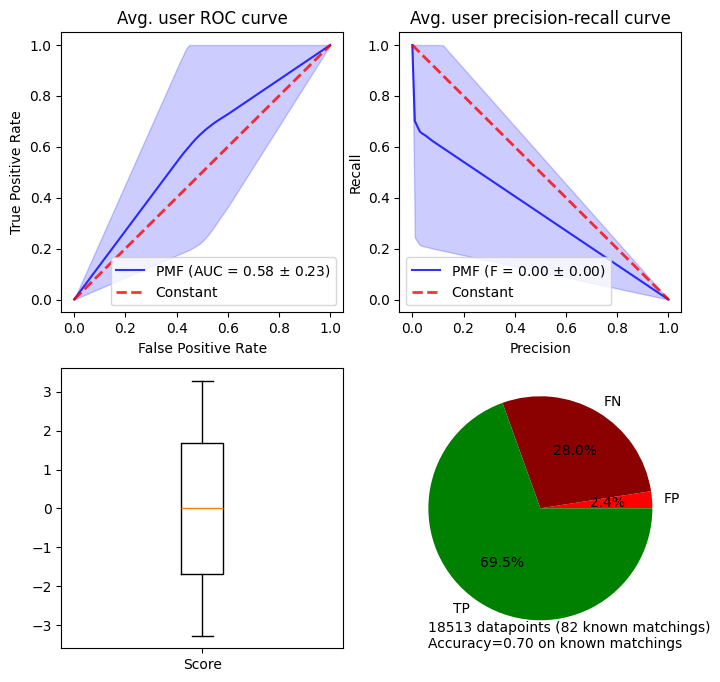

In [92]:

# Validation
# disease-wise metrics
metrics, plot_args = compute_metrics(
    scores, predictions, test_dataset, metrics=metrics_list, k=k, beta=beta, verbose=1
)
# run all metrics
plot_args.update({"model_name": "PMF", "figsize": (8, 8)})
plot_metrics(**plot_args)


In [93]:
# dataset-wide metrics
y_test = (test_dataset.folds.toarray() * test_dataset.ratings.toarray()).ravel()
y_test[y_test < 1] = 0

whole_metrics = [
    AUC(y_test, scores.toarray().ravel(), k, beta),
    Rscore(y_test, scores.toarray().ravel(), k, beta),
    MRR(y_test, scores.toarray().ravel(), k, beta),
    RP(y_test, scores.toarray().ravel(), k, beta),
    PrecisionK(y_test, scores.toarray().ravel(), k, beta),
    RecallK(y_test, scores.toarray().ravel(), k, beta),
    F1K(y_test, scores.toarray().ravel(), k, beta),
    AP(y_test, scores.toarray().ravel(), k, beta),
    MAP(y_test, scores.toarray().ravel(), k, beta),
    DCGk(y_test, scores.toarray().ravel(), k, beta),
    NDCGk(y_test, scores.toarray().ravel(), k, beta),
    MeanRank(y_test, scores.toarray().ravel(), k, beta),
    HRk(y_test, scores.toarray().ravel(), k, beta),
    ERR(y_test, scores.toarray().ravel(), k, beta),
]

results = pd.concat(
    (
        pd.DataFrame(
            [whole_metrics],
            index=["Value"],
            columns=[
                "AUC",
                "Rscore",
                "MRR",
                "RP",
                "PrecisionK",
                "RecallK",
                "F1K",
                "AP",
                "MAP",
                "DCGk",
                "NDCGk",
                "MeanRank",
                "HRk",
                "ERR",
            ],
        ).T,
        metrics,
    ),
    axis=1,
)

results.head()

,Value,Average,StandardDeviation
AUC,0.704159,0.582821,0.225721
Rscore,0.029750,0.039749,0.090071
MRR,0.083333,0.054633,0.087174
RP,0.000866,0.031445,0.029384
PrecisionK,0.000000,0.017544,0.056577
